In [9]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from torchvision.models import resnet50

import vision_transformer as vits

from pathlib import Path
import random

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [10]:
patch_size = 16
size = (1200, 1200)

transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Resize(size),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [11]:
files = [str(file) for file in Path("../data/mini_ship_spotting_single/").glob("*/*.jpg")]
print(len(files))

24550


In [12]:
def load_model(model_savename, model_type='vit_tiny'):
    patch_size = 16
    size = (1600, 1600)
    if model_type == 'vit_tiny':
        model = vits.__dict__['vit_tiny'](patch_size=patch_size, num_classes=4)
    elif model_type == 'vit_small':
        model = vits.__dict__['vit_small'](patch_size=patch_size, num_classes=4)
    elif model_type == 'vit_base':
        model = vits.__dict__['vit_base'](patch_size=patch_size, num_classes=4)    
    elif model_type == 'resnet50':
        print('resnet does not have attention maps...')
        return
        #model = resnet50(pretrained=False)
    
    checkpoint = "teacher"
    pretrained_weights = f"models/{model_savename}"

    if os.path.isfile(pretrained_weights):
        state_dict = torch.load(pretrained_weights, map_location="cpu")
        if checkpoint is not None and checkpoint in state_dict:
            #print(f"Take key {checkpoint} in provided checkpoint dict")
            state_dict = state_dict[checkpoint]
        # remove `module.` prefix
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

        #print(state_dict.keys())

        msg = model.load_state_dict(state_dict, strict=False)
        #print(f"Loaded {model_savename}")
        #print('Pretrained weights found at {} and loaded with msg: {}'.format('checkpoint.pth', msg))
        
    else:
        print("Failed to load")
        return None, False
        
    for p in model.parameters():
        p.requires_grad = False
        
    model.eval()
    model.to(device)
    
    return model, True
        
    

In [13]:
def get_attention(model, image_name=None):
    if image_name == None:
        rand_img = random.randint(0, len(files))
        image_name = files[rand_img]
        
    img_npy = Image.open(image_name)
    img_npy = img_npy.convert('RGB').resize(size)

    img = transform(img_npy)

    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))  

    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()

    attentions_mean = np.mean(attentions, axis=0)
    
    return attentions, attentions_mean

In [18]:
import os
import random
from tqdm import tqdm

models_folder = "models"
size = (1600, 1600)

models = [f.name for f in os.scandir(models_folder) if f.is_file()]
models.remove("checkpoint0200.pth")
# models = ['checkpoint0000.pth', 'checkpoint0100.pth', 'checkpoint0200.pth',
#           'checkpoint0400.pth', 'checkpoint0600.pth', 'checkpoint0800.pth', 'checkpoint1000.pth']

#models = ['tiny_checkpoint1000.pth', 'small_checkpoint.pth', 'base_checkpoint.pth']
models.sort()

print(models)

['vit_base_ship_experiement_200.pth']


../data/mini_ship_spotting_single/Tanker/3027633.jpg


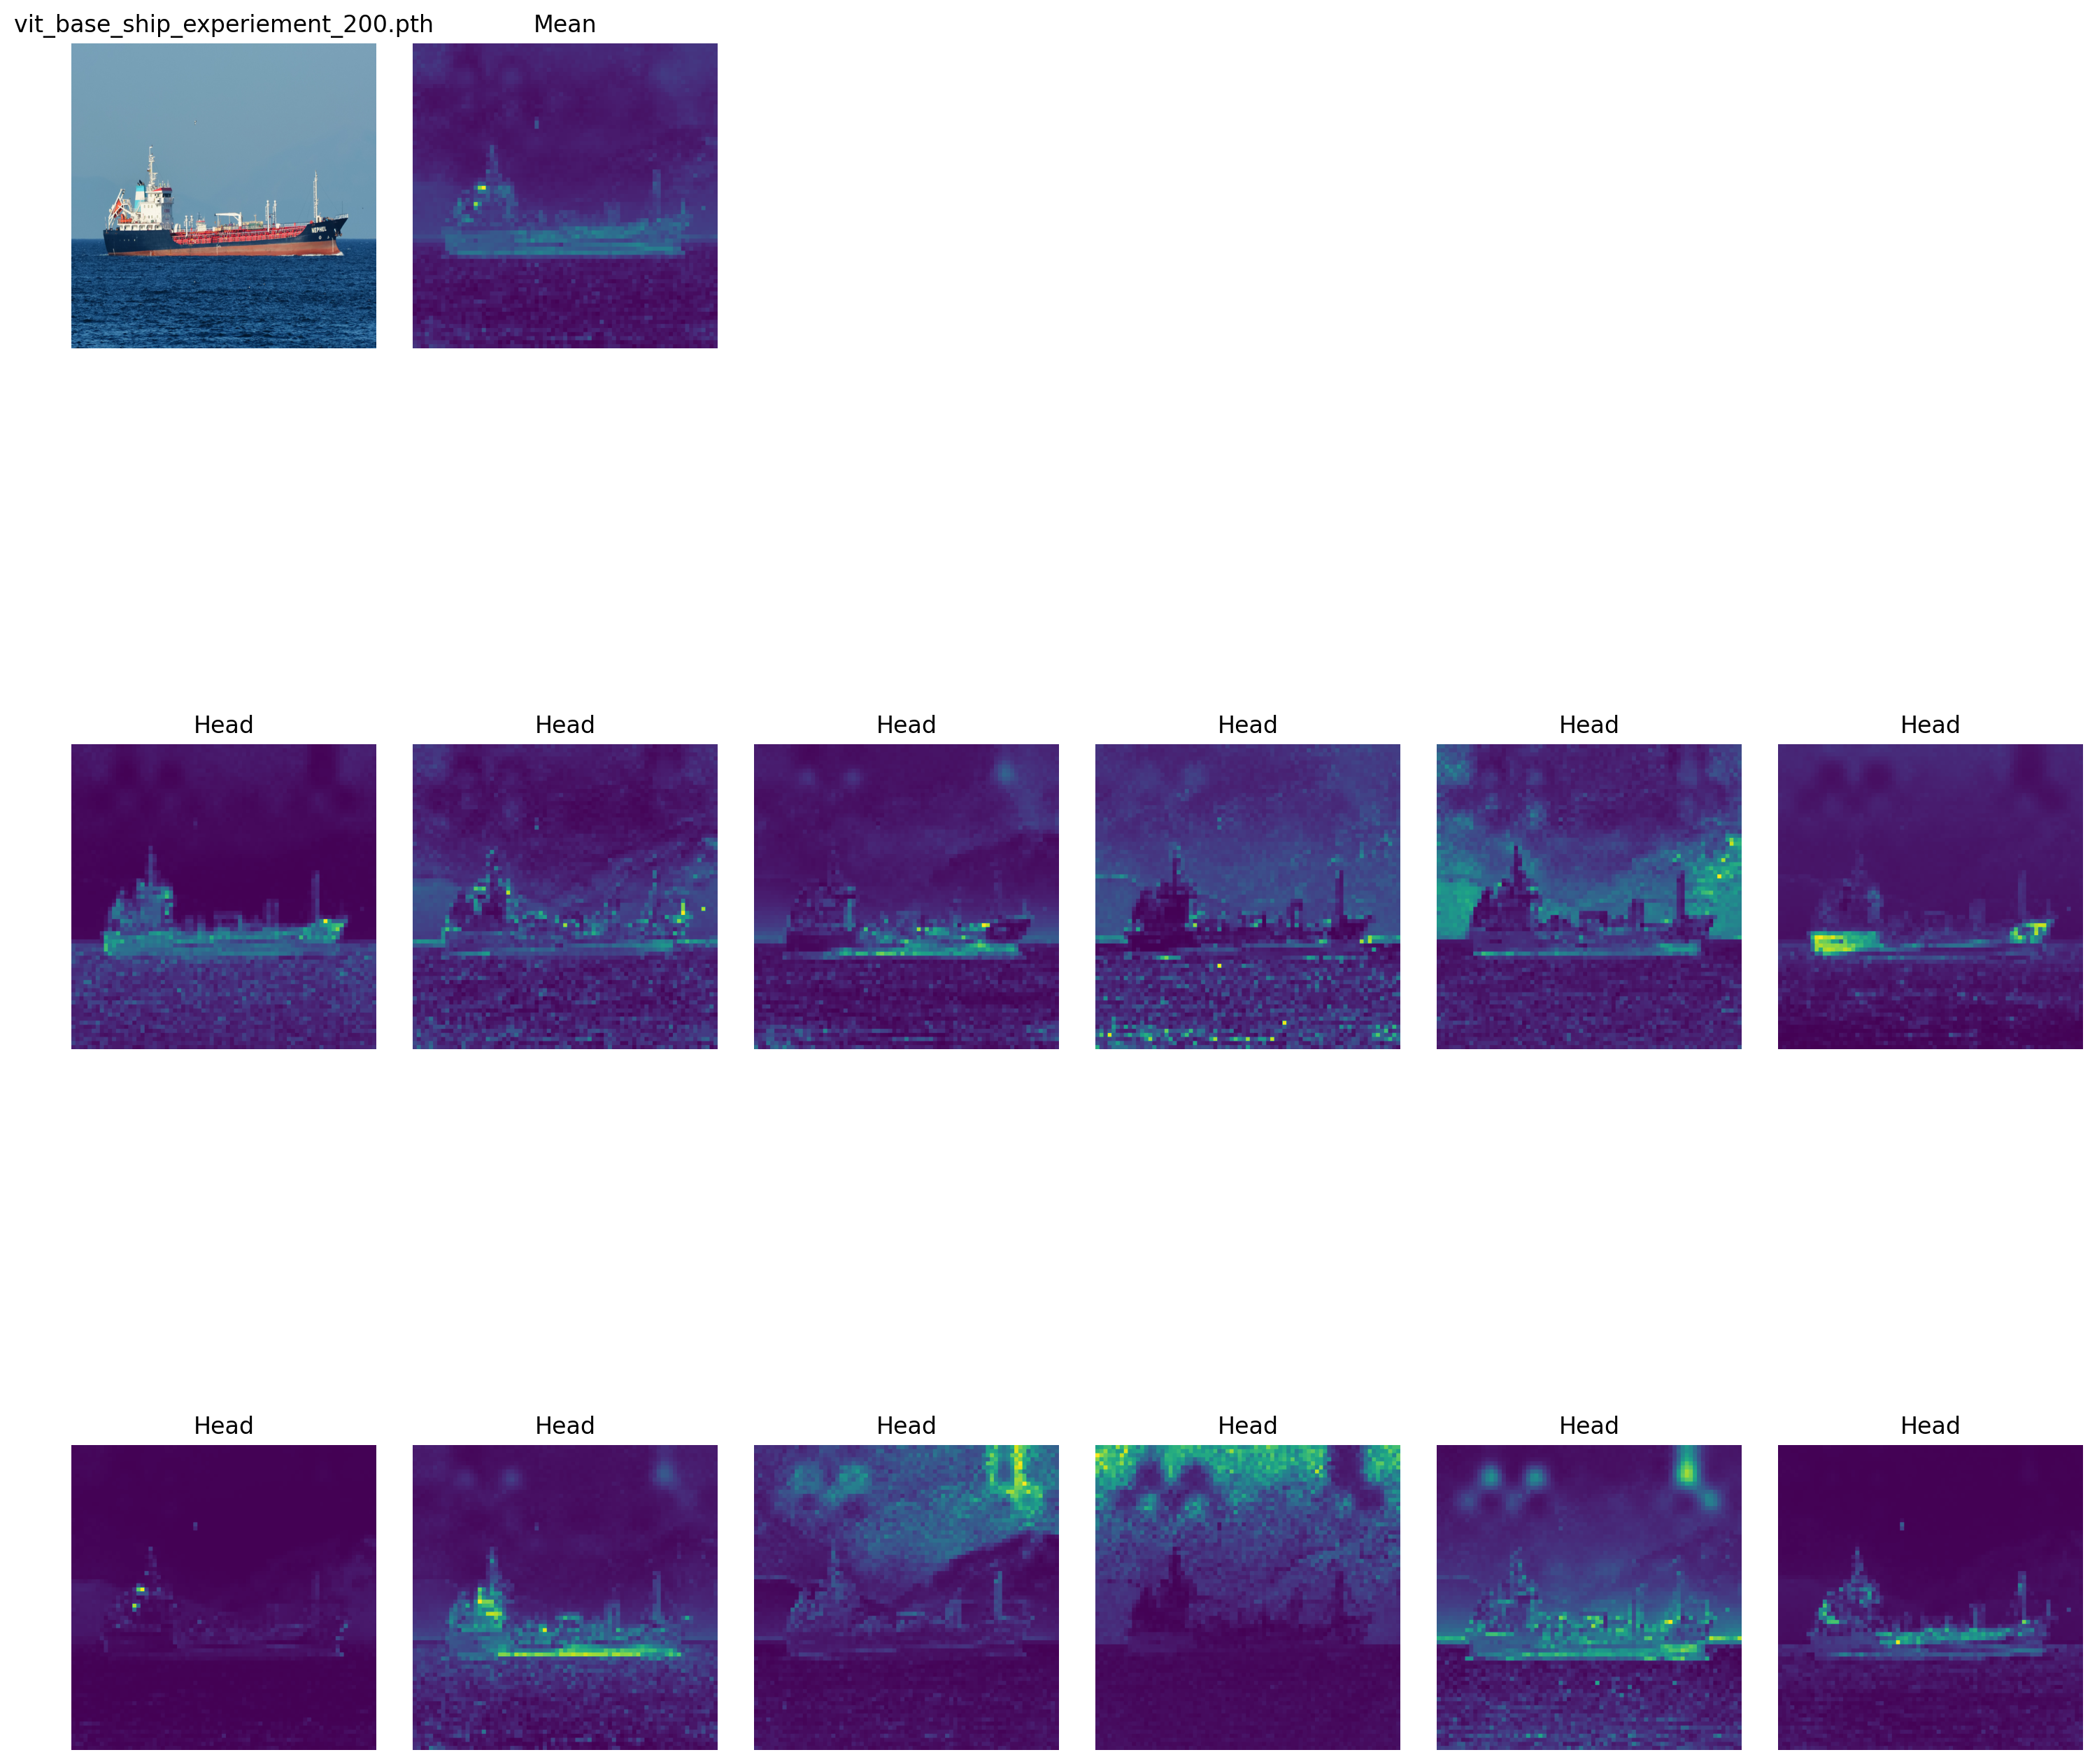

In [19]:
rand_img = random.randint(0, len(files))
image_name = files[rand_img]
img_npy = Image.open(files[rand_img])

print(files[rand_img])
img_npy = img_npy.convert('RGB').resize(size)

plt.figure(figsize=(15, 15), dpi=200)

rows = len(models) * 2
row = 0
for i, model_savename in enumerate(tqdm(models, leave=False)):
    
    if 'small' in model_savename:
        model, load_status = load_model(model_savename, 'vit_small')
    elif 'tiny' in model_savename:
        model, load_status = load_model(model_savename, 'vit_tiny')
    elif 'base' in model_savename:
        model, load_status = load_model(model_savename, 'vit_base')
        rows += 1
        
    if load_status is not True:
        print(f"Something went wrong for {model_savename}, skipping this iteration.")
        continue
                 
    attentions, attentions_mean = get_attention(model, image_name)
    
    plt.subplot(rows, 6, row*6 + 1)
    plt.tight_layout()

    plt.title(f"{model_savename}")
    plt.imshow(img_npy)
    plt.axis("off")

    # Plot mean
    plt.subplot(rows, 6 , row* 6 + 2)
    plt.title(f"Mean")
    plt.imshow(attentions_mean)
    plt.axis("off")
    row += 1
    
    nh = len(attentions)
    # Plot Heads
    for j in range(nh):
        plt.subplot(rows, 6, row*6 + j + 1)
        plt.title(f"Head")
        plt.imshow(attentions[j])
        plt.axis("off")
    
    if 'base' in model_savename:
        row += 2
    else:
        row += 1

    

../data/mini_ship_spotting_single/Tanker/3058652.jpg


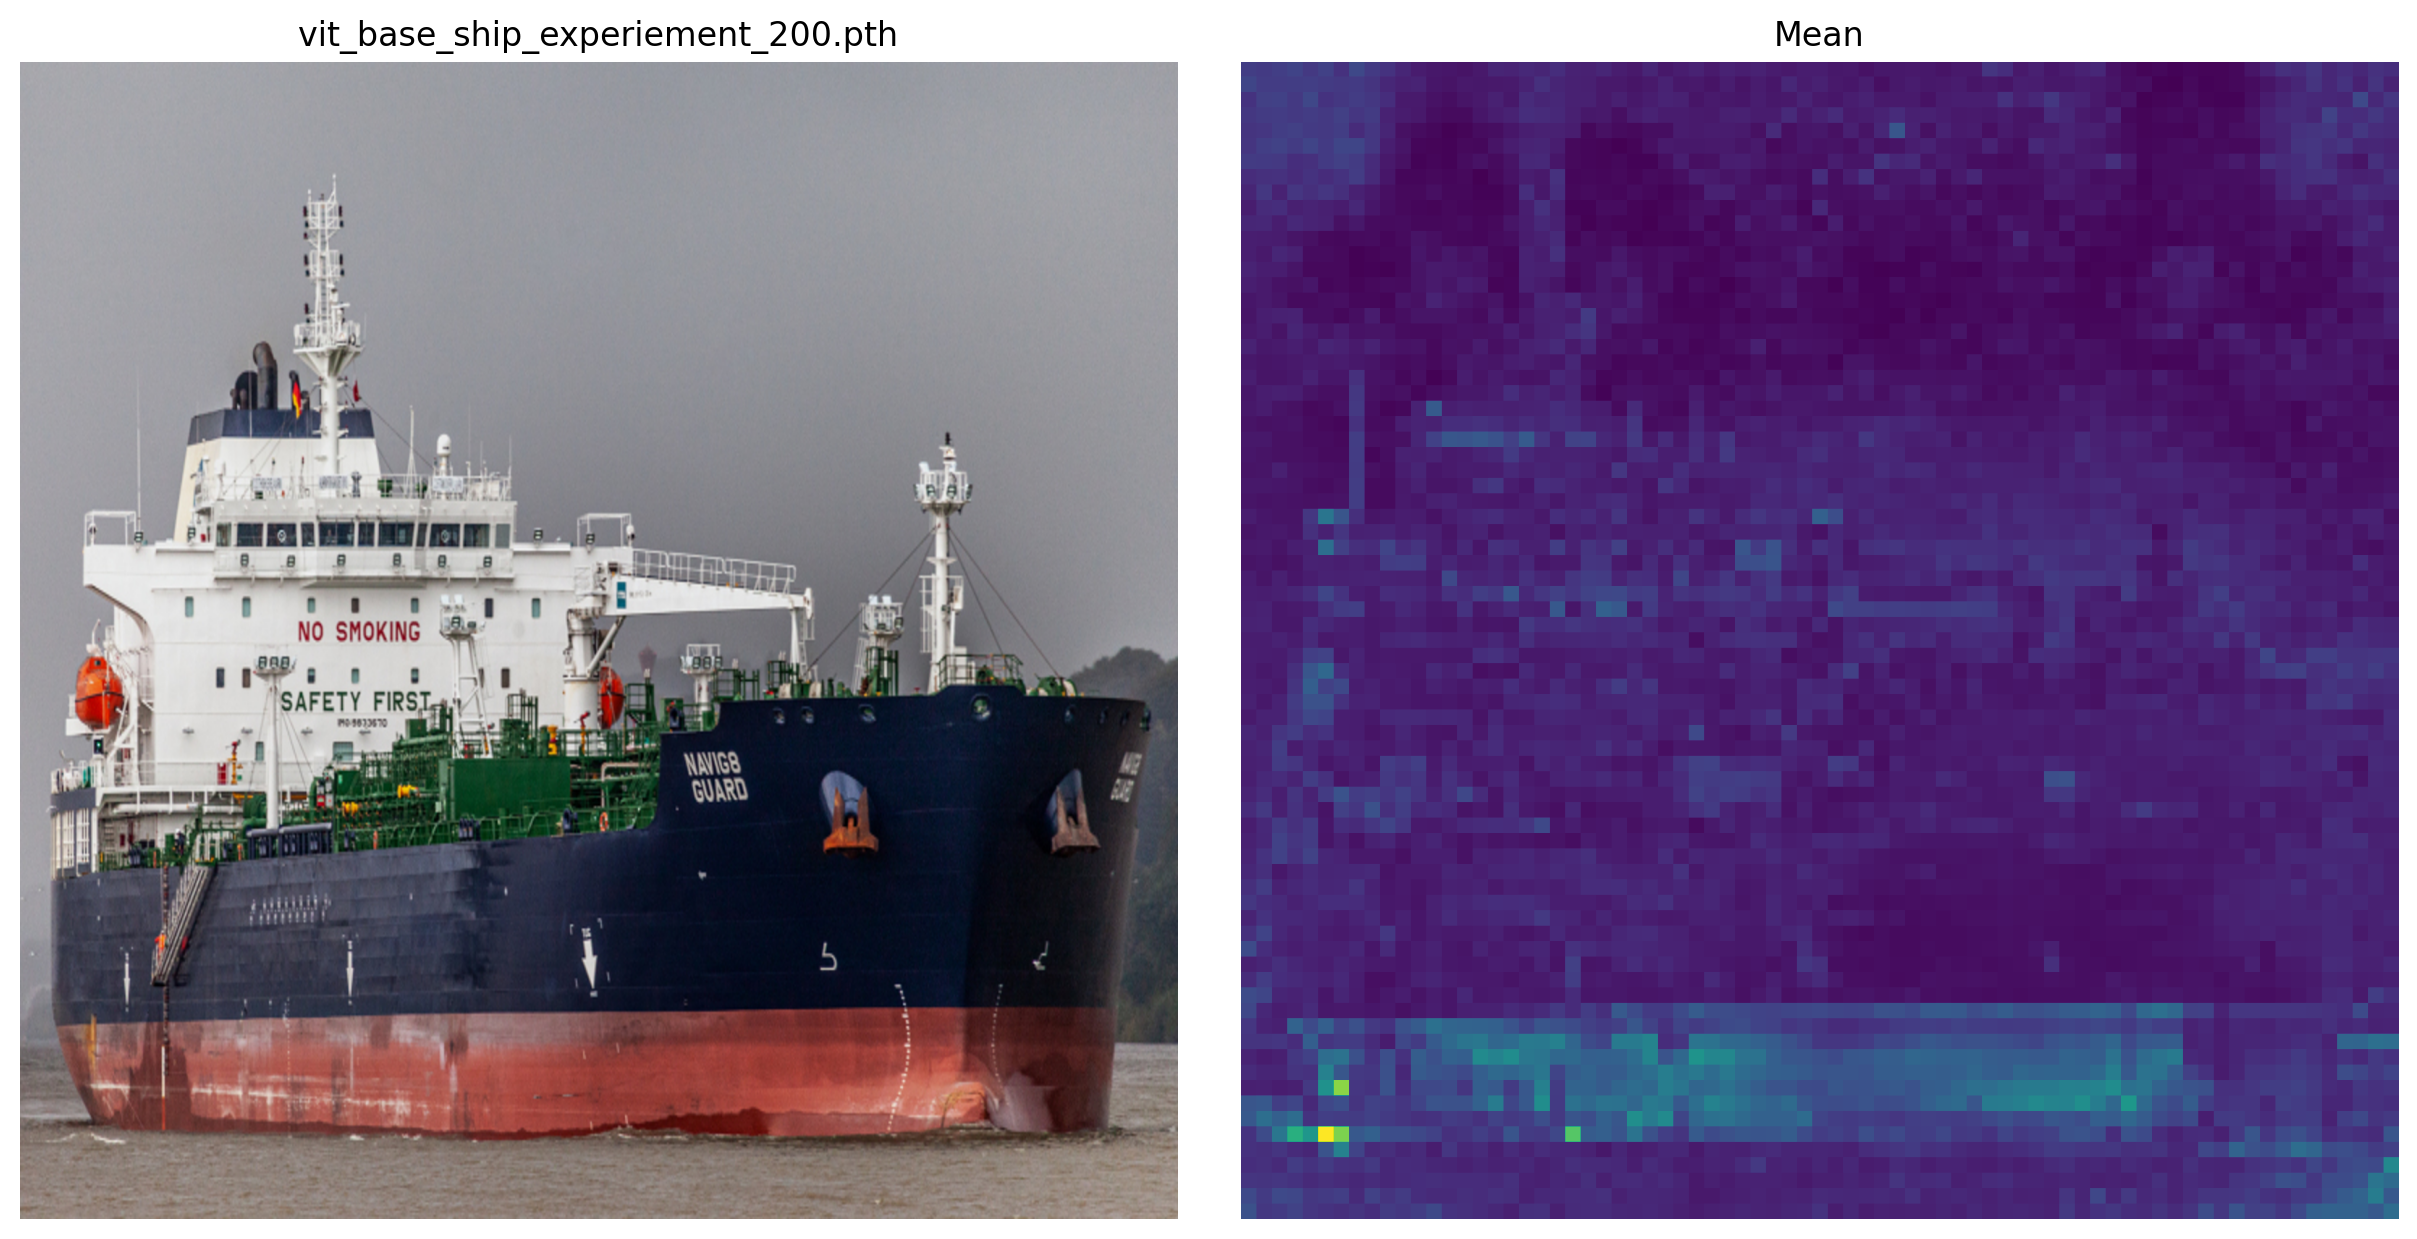

In [20]:
rand_img = random.randint(0, len(files))
image_name = files[rand_img]
img_npy = Image.open(files[rand_img])

print(files[rand_img])
img_npy = img_npy.convert('RGB').resize(size)

plt.figure(figsize=(12, 12), dpi=200)

rows = len(models)
row = 0
for i, model_savename in enumerate(tqdm(models, leave=False)):
    
    if 'small' in model_savename:
        model, load_status = load_model(model_savename, 'vit_small')
    elif 'tiny' in model_savename:
        model, load_status = load_model(model_savename, 'vit_tiny')
    elif 'base' in model_savename:
        model, load_status = load_model(model_savename, 'vit_base')
        rows += 1
    else:
        model, load_status = load_model(model_savename, 'vit_small')
        
    if load_status is not True:
        print(f"Something went wrong for {model_savename}, skipping this iteration.")
        continue
                 
    attentions, attentions_mean = get_attention(model, image_name)
    
    plt.subplot(rows, 2, row*2 + 1)
    plt.tight_layout(pad=0.0)

    plt.title(f"{model_savename}")
    plt.imshow(img_npy)
    plt.axis("off")

    # Plot mean
    plt.subplot(rows, 2 , row* 2 + 2)
    plt.tight_layout(pad=0.0)
    plt.title(f"Mean")
    plt.imshow(attentions_mean)
    plt.axis("off")
    row += 1
    
    